## importing latest ECDC data on covid-19 situation from:

https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide


In [1]:
import requests

In [2]:
from requests import session

In [3]:
url = 'https://opendata.ecdc.europa.eu/covid19/casedistribution/json'
r = requests.get(url)
data_json = r.json()

In [4]:
import pandas as pd
covid_data = pd.json_normalize(data_json,'records')

In [5]:
covid_data['cases'] = covid_data['cases'].astype(int)
covid_data['deaths'] = covid_data['deaths'].astype(int)

In [6]:
covid_data.continentExp.value_counts(normalize=True)

Europe     0.317212
Asia       0.248188
Africa     0.198952
America    0.197204
Oceania    0.035154
Other      0.003289
Name: continentExp, dtype: float64

In [7]:
covid_data_deaths_per_person = covid_data.groupby('countryterritoryCode').sum()[['cases', 'deaths']]
covid_data_deaths_per_person =  pd.DataFrame(data=covid_data_deaths_per_person)

In [8]:
covid_19_data_countries = covid_data.drop_duplicates(subset='countriesAndTerritories')
covid_19_data_countries = covid_19_data_countries[['countriesAndTerritories', 
                                                  'countryterritoryCode', 
                                                  'popData2018', 
                                                  'continentExp']]

In [9]:
covid_19_databse = pd.merge(covid_19_data_countries,
                               covid_data_deaths_per_person, 
                               on='countryterritoryCode')
covid_19_databse

,countriesAndTerritories,countryterritoryCode,popData2018,continentExp,cases,deaths
0,Afghanistan,AFG,37172386,Asia,11173,219
1,Aruba,ABW,105845,America,101,3
2,Albania,ALB,2866376,Europe,1004,32
3,Algeria,DZA,42228429,Africa,8503,609
4,Angola,AGO,30809762,Africa,69,4
...,...,...,...,...,...,...
205,Yemen,YEM,28498687,Asia,237,45
206,Zambia,ZMB,17351822,Africa,920,7
207,Zimbabwe,ZWE,14439018,Africa,56,4
208,Spain,ESP,46723749,Europe,235400,26834


In [10]:
covid_19_databse['popData2018'] = pd.to_numeric(covid_19_databse['popData2018'])

In [11]:
covid_19_databse['case_per_milion'] = covid_19_databse['cases'] / covid_19_databse['popData2018'] *1000000
covid_19_databse['deaths_per_milion'] = covid_19_databse['deaths'] / covid_19_databse['popData2018'] *1000000

In [12]:
covid_19_databse.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   countriesAndTerritories  210 non-null    object 
 1   countryterritoryCode     210 non-null    object 
 2   popData2018              205 non-null    float64
 3   continentExp             210 non-null    object 
 4   cases                    210 non-null    int64  
 5   deaths                   210 non-null    int64  
 6   case_per_milion          205 non-null    float64
 7   deaths_per_milion        205 non-null    float64
dtypes: float64(3), int64(2), object(3)
memory usage: 14.8+ KB


In [13]:
# COVID-19 anaysis - importing GDP per capita database for 2018 from https://opendata.eulerhermes.com for 239 coutries

url = 'https://opendata.eulerhermes.com/api/records/1.0/search/?dataset=gdp-1960-2017&q=&rows=300&facet=country_name&facet=year&refine.year=2018'

import requests
result = requests.get(url)
data = result.json()
data_records = data['records']
type(data_records)

data_counties_country_name = []
data_counties_country_code = []
data_counties_gdp_per_capita_current_us = []
data_counties_year = []

for field in data_records:
    data_counties_country_name.append(dict(field['fields'])['country_name'])
    data_counties_country_code.append(dict(field['fields'])['country_code'])
    data_counties_gdp_per_capita_current_us.append(dict(field['fields'])['gdp_per_capita_current_us'])
    data_counties_year.append(dict(field['fields'])['year'])
    
gdp_df = pd.DataFrame(list(zip(
                                data_counties_country_code,
                                data_counties_gdp_per_capita_current_us)),
                                columns=['countryterritoryCode', 'gdp_per_capita'])


gdp_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   countryterritoryCode  239 non-null    object 
 1   gdp_per_capita        239 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.9+ KB


In [14]:
covid_19_databse = pd.merge(covid_19_databse,
                               gdp_df, 
                               on='countryterritoryCode')
covid_19_databse

,countriesAndTerritories,countryterritoryCode,popData2018,continentExp,cases,deaths,case_per_milion,deaths_per_milion,gdp_per_capita
0,Afghanistan,AFG,37172386.0,Asia,11173,219,300.572581,5.891470,520.896603
1,Albania,ALB,2866376.0,Europe,1004,32,350.268074,11.163923,5268.848504
2,Algeria,DZA,42228429.0,Africa,8503,609,201.357242,14.421564,4114.715061
3,Angola,AGO,30809762.0,Africa,69,4,2.239550,0.129829,3432.385736
4,Andorra,AND,77006.0,Europe,763,51,9908.318832,662.286056,42029.762737
...,...,...,...,...,...,...,...,...,...
176,Vietnam,VNM,95540395.0,Asia,326,0,3.412169,0.000000,2566.596950
177,Yemen,YEM,28498687.0,Asia,237,45,8.316173,1.579020,944.408499
178,Zambia,ZMB,17351822.0,Africa,920,7,53.020369,0.403416,1539.900158
179,Zimbabwe,ZWE,14439018.0,Africa,56,4,3.878380,0.277027,2146.996385


In [15]:
covid_19_databse.drop(columns='countryterritoryCode')

,countriesAndTerritories,popData2018,continentExp,cases,deaths,case_per_milion,deaths_per_milion,gdp_per_capita
0,Afghanistan,37172386.0,Asia,11173,219,300.572581,5.891470,520.896603
1,Albania,2866376.0,Europe,1004,32,350.268074,11.163923,5268.848504
2,Algeria,42228429.0,Africa,8503,609,201.357242,14.421564,4114.715061
3,Angola,30809762.0,Africa,69,4,2.239550,0.129829,3432.385736
4,Andorra,77006.0,Europe,763,51,9908.318832,662.286056,42029.762737
...,...,...,...,...,...,...,...,...
176,Vietnam,95540395.0,Asia,326,0,3.412169,0.000000,2566.596950
177,Yemen,28498687.0,Asia,237,45,8.316173,1.579020,944.408499
178,Zambia,17351822.0,Africa,920,7,53.020369,0.403416,1539.900158
179,Zimbabwe,14439018.0,Africa,56,4,3.878380,0.277027,2146.996385


In [104]:
covid_19_databse.info()

covid_19_databse['population_size'] = 'zzz'

def func(x):
    if 0 < x <= 2000000:
        return 'small'
    elif 10 < x <= 60000000:
        return 'medium'
    return 'big'
covid_19_databse['population_size'] = covid_19_databse['popData2018'].apply(func)

def func(x):
    if 0 < x <= 1000:
        return 'small'
    elif 10 < x <= 5000:
        return 'medium'
    return 'big'
covid_19_databse['gdp_category'] = covid_19_databse['gdp_per_capita'].apply(func)

def func(x):
    if 0 < x <= 10:
        return 'small'
    elif 10 < x <= 50:
        return 'medium'
    return 'big'
covid_19_databse['death_category'] = covid_19_databse['deaths_per_milion'].apply(func)

pd.crosstab(covid_19_databse['continentExp'],
            covid_19_databse['death_category'],
            covid_19_databse['deaths_per_milion'],
            aggfunc='count')

pd.crosstab(covid_19_databse['continentExp'],
            covid_19_databse['gdp_category'],
            covid_19_databse['deaths_per_milion'],
            aggfunc='median')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181 entries, 0 to 180
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   countriesAndTerritories  181 non-null    object 
 1   countryterritoryCode     181 non-null    object 
 2   popData2018              181 non-null    float64
 3   continentExp             181 non-null    object 
 4   cases                    181 non-null    int64  
 5   deaths                   181 non-null    int64  
 6   case_per_milion          181 non-null    float64
 7   deaths_per_milion        181 non-null    float64
 8   gdp_per_capita           181 non-null    float64
 9   population_size          181 non-null    object 
 10  gdp_size                 181 non-null    object 
 11  death_category           181 non-null    object 
 12  gdp_category             181 non-null    object 
dtypes: float64(4), int64(2), object(7)
memory usage: 24.8+ KB


gdp_category,big,medium,small
continentExp,,,
Africa,3.527615,1.412833,1.204008
America,15.106140,5.606827,2.786974
Asia,6.686209,0.427970,5.054480
Europe,51.176947,15.109540,NaN
Oceania,4.298434,0.000000,NaN


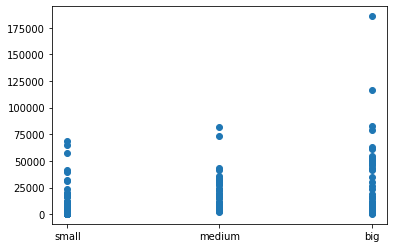

In [101]:
import matplotlib.pyplot as plt

plt.scatter(covid_19_databse['death_category'],covid_19_databse['gdp_per_capita'])

In [95]:
covid_19_databse_with_dummies = pd.get_dummies(covid_19_databse, columns=['continentExp'])

covid_19_databse_with_dummies['popData2018'] = covid_19_databse_with_dummies['popData2018'].astype(int)
covid_19_databse_with_dummies['deaths_per_milion'] = covid_19_databse_with_dummies['deaths_per_milion'].astype(int)
covid_19_databse_with_dummies['gdp_per_capita'] = covid_19_databse_with_dummies['gdp_per_capita'].astype(int)
covid_19_databse_with_dummies['case_per_milion'] = covid_19_databse_with_dummies['case_per_milion'].astype(int)
covid_19_databse_with_dummies.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 181 entries, 0 to 180
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   countriesAndTerritories  181 non-null    object
 1   countryterritoryCode     181 non-null    object
 2   popData2018              181 non-null    int64 
 3   cases                    181 non-null    int64 
 4   deaths                   181 non-null    int64 
 5   case_per_milion          181 non-null    int64 
 6   deaths_per_milion        181 non-null    int64 
 7   gdp_per_capita           181 non-null    int64 
 8   population_size          181 non-null    object
 9   gdp_size                 181 non-null    object
 10  death_category           181 non-null    object
 11  gdp_category             181 non-null    object
 12  continentExp_Africa      181 non-null    uint8 
 13  continentExp_America     181 non-null    uint8 
 14  continentExp_Asia        181 non-null    u

In [22]:

covid_19_databse_with_dummies.describe()

,popData2018,cases,deaths,case_per_milion,deaths_per_milion,gdp_per_capita,continentExp_Africa,continentExp_America,continentExp_Asia,continentExp_Europe,continentExp_Oceania
count,1.810000e+02,1.810000e+02,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000
mean,4.080844e+07,2.937022e+04,1869.403315,1054.779006,45.817680,15986.790055,0.287293,0.204420,0.220994,0.254144,0.033149
std,1.488657e+08,1.337814e+05,8806.362751,1933.992728,119.944686,23610.816115,0.453755,0.404396,0.416068,0.436586,0.179523
min,3.145800e+04,2.000000e+00,0.000000,0.000000,0.000000,271.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.254126e+06,3.240000e+02,6.000000,83.000000,1.000000,2028.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.883800e+06,1.689000e+03,36.000000,259.000000,5.000000,6344.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.949596e+07,1.119300e+04,261.000000,1195.000000,29.000000,19442.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.392730e+09,1.662302e+06,98220.000000,16344.000000,815.000000,185741.000000,1.000000,1.000000,1.000000,1.000000,1.000000
